#  Named Entity Recognition Using Bi-LSTM + CRF

### The model use Bi-directional LSTM with Word / Character representation and CRF for sequence tagging

Perform keras backend

- Word Embedding : 100 dimension
- Char Embedding : Bi-LSTM training from scratch 32 dimension


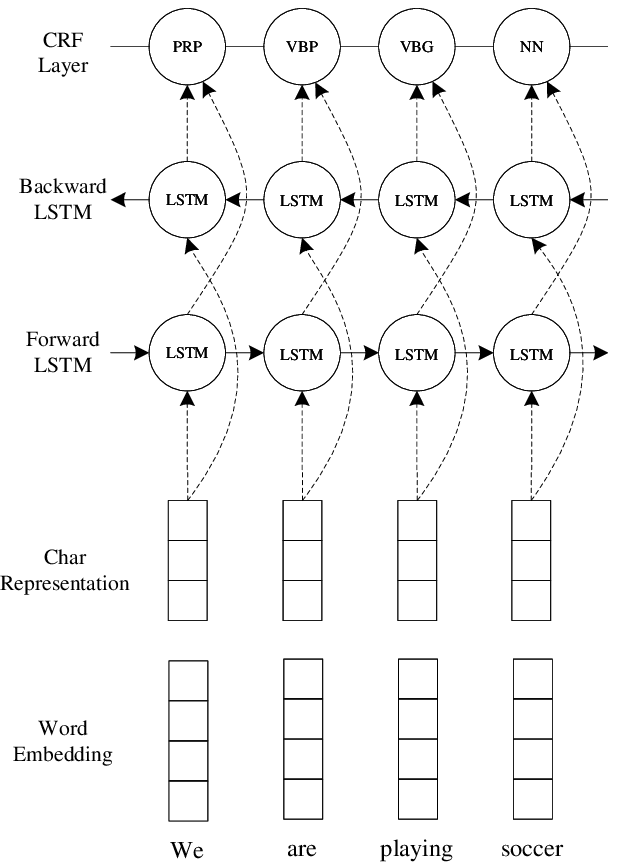

In [ ]:
%tensorflow_version 1.15.5

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15.5`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [ ]:
#!pip install tensorflow==1.15.5
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Data Processing



The dataset provides both Part Of Speech (POS) tags as well as NER tags. Each line contains a token, its POS tag and NER tag. The first token of each sentence also contains a Sentence Number that follows the pattern "Sentence: \d+".

In this section we process this format into a JSON format that our HuggingFace `load_dataset` function can consume easily. Essentially, we convert it into a JSON structure as follows and write it out into JSON-L files. The JSON structure maps 1:1 to the Dataset format as we will see later.

```
{
  "tokens": ["Barack", "Obama", ..., "United", "States", "."],
  "ner_tags": ["B-PER", "I-PER", ..., "B-GPE", "I-GPE", "O"]
}
```

We also split the dataset into three JSON-L files for training, validation, and test using a random-number generation technique.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/

 1million.word2vec.model
 1million.word2vec.model.syn1neg.npy
 1million.word2vec.model.wv.syn0.npy
'58-Benayach-Khansa&67-Elmoussi-Marouane&71-Idnarour-Maryame&83-Merbouh-Hajar&85-Moukhtar-Salsabil.rar'
'83 Merbouh Hajar_Géoéconomie comme forme de diplomatie.pdf'
'83 Merbouh Hajar-Géoéconomie comme forme de diplomatie.pdf'
'Alfresco Working Directory'
 apt_data.tar.bz2
'Attacks & Defences.ipynb'
'ATT&CK MATRICES Group (1).csv'
'ATT&CK MATRICES Group.csv'
'ATT&CK MATRICES Miti.csv'
'ATT&CK MATRICES Tac.csv'
'ATT&CK MATRICES Tec.csv'
'base données com - Feuil1(1)'
 bert
 bestmodel
 cc.en.300.bin
 Classroom
'Colab Notebooks'
 corpus
 corpus1
 cves.xlsx
 CV-Merbouh.pdf
'DL 1 Electronique MP 2019.pdf'
'Document sans titre.gdoc'
 EX1.pdf
 ex2.pdf
 ex3.py
 Examen-Ex1.pdf
 Examen-EX2.pdf
 exercice1.py
'fiche de réinscription pour les 2A et 3A CYCLE Ingénieur (1).docx'
'GestionAchatsSpring (1).zip'
 GestionAchatsSpring.zip
 Gestion-Produits.zip
 glove.6B.300d.txt
'Impl. from scratch.ipyn

In [ ]:
!head /content/drive/MyDrive/ner_dataset.csv

,Sentence #,Word,Tag,POS
0,1,The,O,DT
1,1,Google,B-ExploitTargetObject,NNP
2,1,hacks,O,VBZ
3,1,Operation,B-COMPAIGN,NNP
4,1,Aurora,I-COMPAIGN,NNP
5,1,",",O,","
6,1,named,O,VBD
7,1,by,O,IN
8,1,McAfee,O,NNP


In [ ]:
!pip install transformers datasets 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf

In [ ]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


In [ ]:
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import shutil
import torch

from collections import Counter, defaultdict
from datasets import load_dataset, ClassLabel

In [ ]:
GS_DATA_DIR = "/content/drive/MyDrive/"
DATA_DIR = "data"

NER_FILEPATH = os.path.join(GS_DATA_DIR, "ner_df1.csv")

OUTPUT_FILEPATHS = [
  os.path.join(DATA_DIR, "gmb-train.jsonl"),
  os.path.join(DATA_DIR, "gmb-valid.jsonl"),
  os.path.join(DATA_DIR, "gmb-test.jsonl")
]

BASE_MODEL_NAME = "bert-base-cased"
MODEL_DIR = os.path.join(DATA_DIR, "{:s}-gmb-ner".format(BASE_MODEL_NAME))

In [ ]:
def write_output(tokens, labels, output_files, num_writter):
  assert(len(tokens) == len(labels))
  rec = json.dumps({ "tokens": tokens, "ner_tags": labels })
  dice = random.random()
  if dice <= 0.8:
    output_files[0].write("{:s}\n".format(rec))
    num_written[0] += 1
  else:
    output_files[1].write("{:s}\n".format(rec))
    num_written[1] += 1
os.makedirs(DATA_DIR, exist_ok=True)
output_files = [open(filepath, "w") for filepath in OUTPUT_FILEPATHS]
num_written = [0, 0]
tokens, labels = [], []
with open(NER_FILEPATH, "r", encoding="latin-1") as fner:
  csv_reader = csv.reader(fner)
  next(csv_reader)  # skip header
  s=2
  for row in csv_reader:
    if row[1]==str(s) and len(tokens) > 0:
      # write out current sentence to train / valid / test
      write_output(tokens, labels, output_files, num_written)
      tokens, labels = [], []
      s=s+1
    # accumulate tokens and labels
    tokens.append(row[2])
    labels.append(row[3])
    # if num_written[0] > 1000:
    #   break

if len(tokens) > 0:
  write_output(tokens, labels, output_files, num_written)

[output_file.close() for output_file in output_files]
print(num_written)

[44015, 11127]


## Dataset

We now want to convert our three JSON-L files `train.jsonl`, `validation.jsonl` and `test.jsonl` files into our raw GMB dataset.

First we produce a mapping of name to file path, and call `load_dataset` on it with `format="json"`.

This creates a DatasetDict object with three Datasets identified by the names specified in the `data_files` mapping.

In [ ]:
data_files = {
    "train": OUTPUT_FILEPATHS[0],
   
    "test": OUTPUT_FILEPATHS[1]
}
gmb_dataset = load_dataset("json", data_files=data_files)
gmb_dataset

Using custom data configuration default-37ed0de2cd096ebd


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-37ed0de2cd096ebd/0.0.0/da492aad5680612e4028e7f6ddc04b1dfcec4b64db470ed7cc5f2bb265b9b6b5. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 44015
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 11127
    })
})

## Declare Path for Model and Dataset
Declare user path to load/save model and dataset
In this file include:
- raw path
- model path
- word embedding path
- dictionary path (char2index / ner2index)

In [ ]:
DATA_PATH='/'
RAW_PATH = f'{DATA_PATH}raw/'
MODEL_PATH = f'{DATA_PATH}model/Keras/WordCharModel/'
W_MODEL_PATH = f'{DATA_PATH}model/w2v/'
Dict_MODEL_PATH = f'{DATA_PATH}model/dictionary/'

# Version

Keras 2.1.6 (pip install keras==2.1.6)

Python 3.5.2

In [ ]:
pip install keras==2.1.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import keras
print(keras.__version__)

2.1.6


Using TensorFlow backend.


# Import Library

In [ ]:
pip install git+https://www.github.com/keras-team/keras-contrib.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-rek979b_
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-rek979b_
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=8e1946ed00337a86afbad6889889798d7351fb70a003826a5cea50b705b06b62
  Stored in directory: /tmp/pip-ephem-wheel-cache-2j3giqly/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


In [ ]:
# Save / Load File
import dill
import pickle

# Plot Graph
import matplotlib.pyplot as plt

# Sklearn Report
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from itertools import chain

# Load Vectors
#from gensim.models import KeyedVectors

# Utility
import numpy as np
import time

# Model Utility
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd

# Keras Model
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Input
from keras.utils import to_categorical
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint

## Load raw dataset (NER)
load dataset that contain word and ner pair (sequence tagging) 

then split train / test dataset via train_test_split (80:20 and fix random seed for reproduction)

the train / test sentence will be result as shown below

In [ ]:
train_sents = []
for i in (gmb_dataset["train"]):
  c=0
  text_inside = []
  for j in i['tokens']:
    text_inside.append((j, i['ner_tags'][c]))
    c=c+1
  train_sents.append(text_inside)
test_sents=[]
for i in (gmb_dataset["test"]):
  c=0
  text_inside = []
  for j in i['tokens']:
    text_inside.append((j, i['ner_tags'][c]))
    c=c+1
  test_sents.append(text_inside)
print(len(train_sents))
print(len(test_sents))
print(train_sents[20])

44015
11127
[('10', 'O'), ('White', 'O'), ('Paper', 'O'), ('Global', 'O'), ('Energy', 'O'), ('Cyberattacks', 'O'), (':', 'O'), ('Night', 'O'), ('Dragon', 'O'), ('The', 'O'), ('attackers', 'O'), ('use', 'O'), ('dynamic', 'B-MALWARE'), ('DNS', 'O'), ('Internet', 'O'), ('name', 'O'), ('services', 'O'), ('accounts', 'O'), ('to', 'O'), ('relay', 'O'), ('C&C', 'O'), ('communications', 'O'), ('or', 'O'), ('temporarily', 'O'), ('associate', 'O'), ('DNS', 'O'), ('addresses', 'O'), ('with', 'O'), ('remote', 'O'), ('servers', 'O'), ('.', 'O')]


## Load Word Embedding



About the word embedding model I'm using :

"The word embedding model produced by Dr. Youngja Park of IBM Research using word2vec applied to a collection of one million documents found on the Web relevant to **cybersecurity**. Tokenization was done using whitespace, resulting in 917,213,530 tokens of which 6,417,554 were unique. The word2vec model has 100 dimensions and a vocabulary of 1,013,092 terms." 

 ref: https://ebiquity.umbc.edu/resource/html/id/379/Cybersecurity-embeddings

In [ ]:
pip install gensim==4.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.0 MB 1.1 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import gensim

# Load pre-trained Word2Vec model.
model = gensim.models.Word2Vec.load('/content/drive/MyDrive/1million.word2vec.model')

In [ ]:
from gensim.models import Word2Vec, KeyedVectors   
model.wv.save_word2vec_format('model.bin', binary=True)

In [ ]:
w2v_model = KeyedVectors.load_word2vec_format('model.bin',binary=True)
w2v_weight=w2v_model.vectors

## Preprocess Word
this process will index word/NER and making a dictionary of all word

set unknown and pad (Padding)

**UNKNOWN word will be replace as ("unknown")**

In [ ]:
word_list=[]
ner_list=[]
cyber2dict = {}

for sent in train_sents:
    for word in sent:
        word_list.append(word[0])
        ner_list.append(word[1])
        
for word in w2v_model.index_to_key:
    cyber2dict[word] = w2v_model[word]

word_list.append("pad")
word_list.append("unknown") #Special Token for Unknown words ("UNK")
ner_list.append("pad")

all_words = sorted(set(word_list))
all_ner = sorted(set(ner_list))
all_cyber2dict = sorted(set(cyber2dict))

word_to_ix = dict((c, i) for i, c in enumerate(all_words)) #convert word to index 
ner_to_ix = dict((c, i) for i, c in enumerate(all_ner)) #convert ner to index
cyber2dict_to_ix = dict((c, i) for i, c in enumerate(cyber2dict)) #convert cyber w2v to index 

ix_to_word = dict((v,k) for k,v in word_to_ix.items()) #convert index to word
ix_to_ner = dict((v,k) for k,v in ner_to_ix.items())  #convert index to ner
ix_to_cyber2dict = dict((v,k) for k,v in cyber2dict_to_ix.items())  #convert index 

n_word = len(word_to_ix)
n_tag = len(ner_to_ix)
n_cyber2dict = len(cyber2dict_to_ix)
print(n_word)
print(n_tag)
print(n_cyber2dict)
print(ner_to_ix)

98476
24
1013092
{'B-ATTACKER': 0, 'B-COMPAIGN': 1, 'B-DATE': 2, 'B-ExploitTargetObject': 3, 'B-INDICATOR': 4, 'B-INFORMATION': 5, 'B-LOC': 6, 'B-MALWARE': 7, 'B-MALWARECHARACTERISTICS': 8, 'B-PRODUCT': 9, 'B-VULNERABILITY': 10, 'I-ATTACKER': 11, 'I-COMPAIGN': 12, 'I-DATE': 13, 'I-ExploitTargetObject': 14, 'I-INDICATOR': 15, 'I-INFORMATION': 16, 'I-LOC': 17, 'I-MALWARE': 18, 'I-MALWARECHARACTERISTICS': 19, 'I-PRODUCT': 20, 'I-VULNERABILITY': 21, 'O': 22, 'pad': 23}


## Preprocess Character

In [ ]:
chars = set([w_i for w in cyber2dict for w_i in w])
char2idx = {c: i + 5 for i, c in enumerate(chars)}

char2idx["pad"] = 0
char2idx["unknown"] = 1
char2idx[" "] = 2

char2idx["$"] = 3
char2idx["#"] = 4
char2idx["!"] = 5
char2idx["%"] = 6
char2idx["&"] = 7
char2idx["*"] = 8
char2idx["+"] = 9
char2idx[","] = 10
char2idx["-"] = 11
char2idx["."] = 12
char2idx["/"] = 13
char2idx[":"] = 14
char2idx[";"] = 15
char2idx["?"] = 16
char2idx["@"] = 17
char2idx["^"] = 18
char2idx["_"] = 19
char2idx["`"] = 20
char2idx["="] = 21
char2idx["|"] = 22
char2idx["~"] = 23
char2idx["'"] = 24
char2idx['"'] = 25

char2idx["("] = 26
char2idx[")"] = 27
char2idx["{"] = 28
char2idx["}"] = 29
char2idx["<"] = 30
char2idx[">"] = 31
char2idx["["] = 32
char2idx["]"] = 33

n_chars = len(char2idx)
print(n_chars)

175


## Save Dictionary for Character and NER

In [ ]:
with open('chardict.pickle', 'wb') as chardict:
    pickle.dump(char2idx, chardict)

In [ ]:
with open('nerdict.pickle', 'wb') as nerdict:
    pickle.dump(ner_to_ix, nerdict)

# Set Parameter and Hyper Parameter

In [ ]:
max_len = 250
max_len_char = 30

character_LSTM_unit = 32
char_embedding_dim = 32
main_lstm_unit = 256 ## Bidirectional 256 + 256 = 512
lstm_recurrent_dropout = 0.5

train_batch_size = 32
train_epochs = 20

## Mapping Function 

In [ ]:
def prepare_sequence_word(input_text):
    idxs = list()
    for word in input_text:
        if word in cyber2dict:
            idxs.append(cyber2dict_to_ix[word])
        else:
            idxs.append(cyber2dict_to_ix["unknown"]) #Use UNK tag for unknown word
    return idxs

def prepare_sequence_target(input_label):
    idxs = [ner_to_ix[w] for w in input_label]
    return idxs

### Split word and label

In [ ]:
input_sent =[ [ word[0] for word in sent]for sent in train_sents ] #words only
train_targets =[ [ word[1] for word in sent]for sent in train_sents ] #NER only

input_test_sent =[ [ word[0] for word in sent]for sent in test_sents ] #words only
test_targets =[ [ word[1] for word in sent]for sent in test_sents ] #NER only

## Prepare Training Dataset

In [ ]:
## Word Training
X_word_tr = [prepare_sequence_word(s) for s in input_sent]
X_word_tr = pad_sequences(maxlen=max_len, sequences=X_word_tr, value=cyber2dict_to_ix["pad"], padding='post', truncating='post')

## Character Training
X_char_tr = []
for sentence in train_sents:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                if(sentence[i][0][j] in char2idx):
                    word_seq.append(char2idx.get(sentence[i][0][j]))
                else:
                    word_seq.append(char2idx.get("unknown"))
            except:
                word_seq.append(char2idx.get("pad"))
        sent_seq.append(word_seq)
    X_char_tr.append(np.array(sent_seq))

## Sequence Label Training
y_tr = [prepare_sequence_target(s) for s in train_targets]
y_tr = pad_sequences(maxlen=max_len, sequences=y_tr, value=ner_to_ix["pad"], padding='post', truncating='post')
y_tr = [to_categorical(i, num_classes=n_tag) for i in y_tr]

## Prepare Testing Dataset

In [ ]:
## Word Testing
X_word_te = [prepare_sequence_word(s) for s in input_test_sent]
X_word_te = pad_sequences(maxlen=max_len, sequences=X_word_te, value=cyber2dict_to_ix["pad"], padding='post', truncating='post')

## Character Testing
X_char_te = []
for sentence in test_sents:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                if(sentence[i][0][j] in char2idx):
                    word_seq.append(char2idx.get(sentence[i][0][j]))
                else:
                    word_seq.append(char2idx.get("unknown"))
            except:
                word_seq.append(char2idx.get("pad"))    
        sent_seq.append(word_seq)
    X_char_te.append(np.array(sent_seq))

## Sequence Label Testing
y_te = [prepare_sequence_target(s) for s in test_targets]
y_te = pad_sequences(maxlen=max_len, sequences=y_te, value=ner_to_ix["pad"], padding='post', truncating='post')
y_te = [to_categorical(i, num_classes=n_tag) for i in y_te]

# Initial Keras Model

In [ ]:
# Word Input
word_in = Input(shape=(max_len,), name='word_input_')

# Word Embedding Using Tt
word_embeddings = Embedding(input_dim=n_cyber2dict,
                            output_dim=100,
                            weights = [w2v_weight],input_length=max_len,
                            mask_zero=False,
                            name='word_embedding', trainable=False)(word_in)

# Character Input
char_in = Input(shape=(max_len, max_len_char,), name='char_input')

# Character Embedding
emb_char = TimeDistributed(Embedding(input_dim=n_chars, output_dim=char_embedding_dim, 
                           input_length=max_len_char, mask_zero=False))(char_in)

# Character Sequence to Vector via BiLSTM
char_enc = TimeDistributed(Bidirectional(LSTM(units=character_LSTM_unit, return_sequences=False, recurrent_dropout=lstm_recurrent_dropout)))(emb_char)


# Concatenate All Embedding
all_word_embeddings = concatenate([word_embeddings, char_enc])
all_word_embeddings = SpatialDropout1D(0.3)(all_word_embeddings)

# Main Model BiLSTM
main_lstm = Bidirectional(LSTM(units=main_lstm_unit, return_sequences=True,
                               recurrent_dropout=lstm_recurrent_dropout))(all_word_embeddings)
main_lstm = TimeDistributed(Dense(50, activation="relu"))(main_lstm)

# CRF
crf = CRF(n_tag)  # CRF layer
out = crf(main_lstm)  # output

# Model
model = Model([word_in, char_in], out)

model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         (None, 250, 30)      0                                            
__________________________________________________________________________________________________
word_input_ (InputLayer)        (None, 250)          0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 250, 30, 32)  5600        char_input[0][0]                 
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 250, 100)     101309200   word_input_[0][0]                
__________________________________________________________________________________________________
time_distr

# Training Model

save best model 

In [ ]:
filepath="weights-improvement-{epoch:02d}-{val_crf_viterbi_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_crf_viterbi_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))
                     ],
                     np.array(y_tr),
                     batch_size=train_batch_size, epochs=train_epochs, verbose=1,callbacks=callbacks_list,
                     validation_data=(
                     [X_word_te,
                     np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))
                     ],
                     np.array(y_te))
                   )



Train on 44015 samples, validate on 11127 samples
Epoch 1/20
44015/44015 [==============================] - 1128s 26ms/step - loss: 0.0924 - crf_viterbi_accuracy: 0.9741 - val_loss: 0.0406 - val_crf_viterbi_accuracy: 0.9853

Epoch 00001: val_crf_viterbi_accuracy improved from -inf to 0.98528, saving model to weights-improvement-01-0.985.hdf5
Epoch 2/20
44015/44015 [==============================] - 1121s 25ms/step - loss: 0.0268 - crf_viterbi_accuracy: 0.9873 - val_loss: 0.0135 - val_crf_viterbi_accuracy: 0.9909

Epoch 00002: val_crf_viterbi_accuracy improved from 0.98528 to 0.99093, saving model to weights-improvement-02-0.991.hdf5
Epoch 3/20
44015/44015 [==============================] - 1120s 25ms/step - loss: 0.0075 - crf_viterbi_accuracy: 0.9918 - val_loss: 0.0014 - val_crf_viterbi_accuracy: 0.9938

Epoch 00003: val_crf_viterbi_accuracy improved from 0.99093 to 0.99378, saving model to weights-improvement-03-0.994.hdf5
Epoch 4/20
44015/44015 [==============================] - 11

# Plot Accuracy Graph

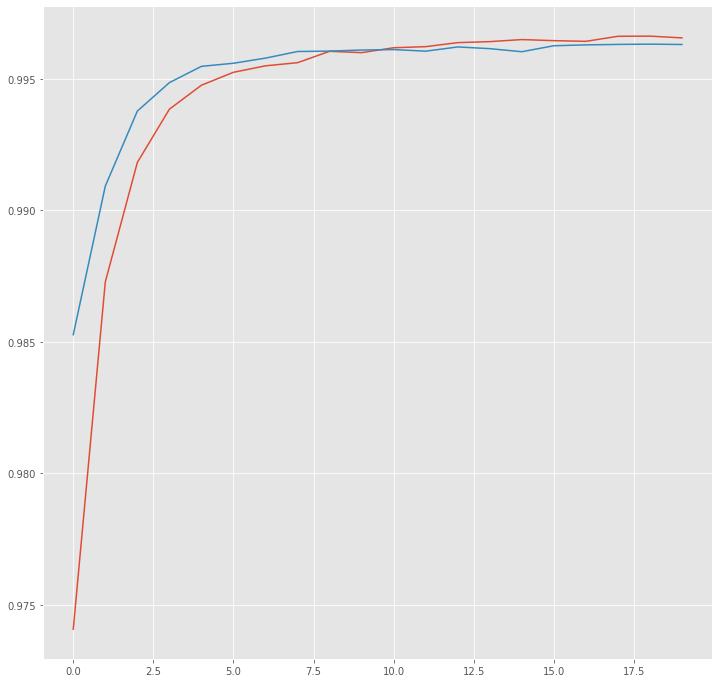

In [ ]:
hist = pd.DataFrame(history.history)

plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["crf_viterbi_accuracy"])
plt.plot(hist["val_crf_viterbi_accuracy"])
plt.show()

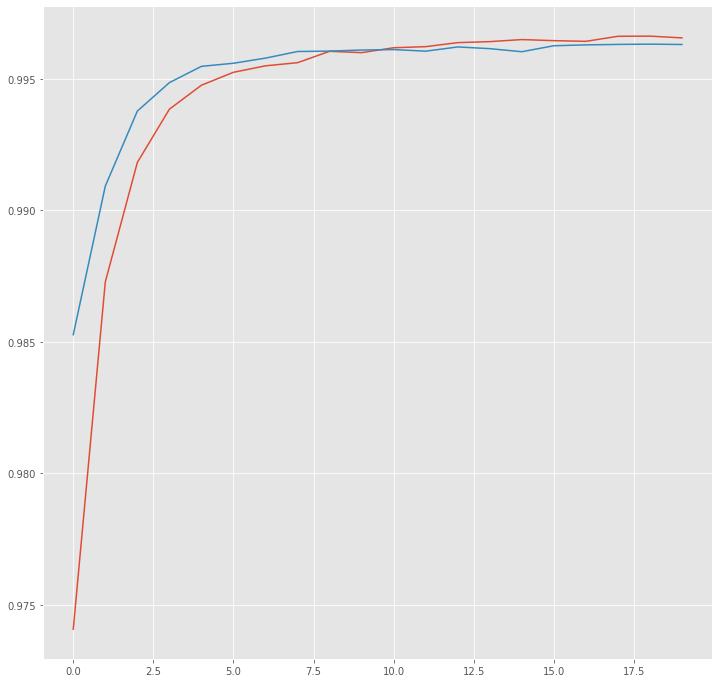

In [ ]:
hist = pd.DataFrame(history.history)

plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["crf_viterbi_accuracy"])
plt.plot(hist["val_crf_viterbi_accuracy"])
plt.show()

# Plot Loss Graph

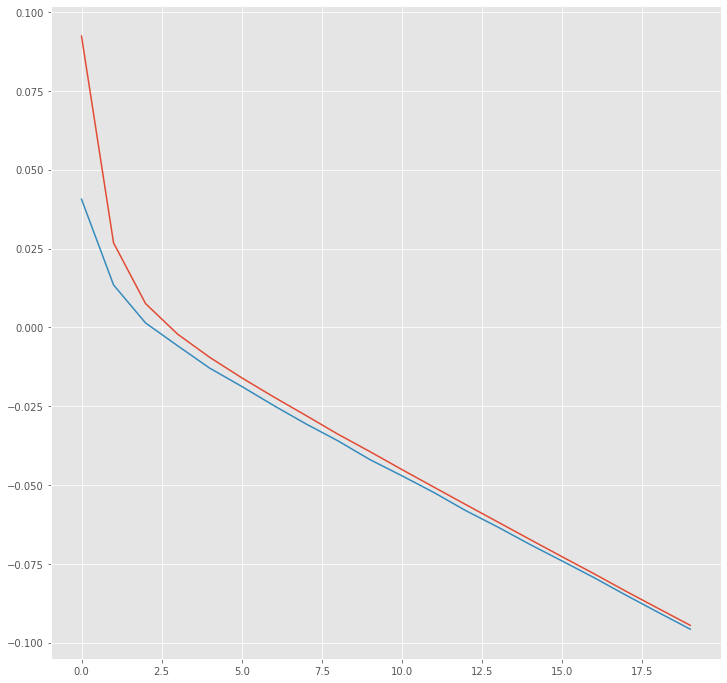

In [ ]:
hist = pd.DataFrame(history.history)

plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

## Save Last Weight Model

In [ ]:
save_filepath="last_weight-50.hdf5"
model.save_weights(save_filepath)

## Load Weight Model

In [ ]:
load_filepath='weights-improvement-19-0.996.hdf5'
model.load_weights(load_filepath)

# Prediction

In [ ]:
pred_model = model.predict([X_word_te,np.array(X_char_te).reshape((len(X_char_te),max_len, max_len_char))], verbose=1)

11127/11127 [==============================] - 59s 5ms/step


In [ ]:
y_pred = []
y_true = []

for i in range(0,len(pred_model)):
    try:
        out = np.argmax(pred_model[i], axis=-1)
        true = np.argmax(y_te[i], axis=-1)
        revert_pred=[ix_to_ner[i] for i in out]
        revert_true=[ix_to_ner[i] for i in true]
        y_pred.append(revert_pred)
        y_true.append(revert_true)
    except:
        print (i)

In [ ]:
def ner_classification_report(y_true, y_pred):
 
    lb = LabelBinarizer()
    y_true_combined = lb.fit_transform(list(chain.from_iterable(y_true)))
    y_pred_combined = lb.transform(list(chain.from_iterable(y_pred)))
    tagset = list(sorted(set(lb.classes_)))
    tagset = tagset[:-1]
    print(tagset)
    class_indices = {cls: idx for idx, cls in enumerate(lb.classes_)}
    
    return classification_report(
        y_true_combined,
        y_pred_combined,
        labels = [class_indices[cls] for cls in tagset],
        target_names = tagset,
        digits=4
    )

In [ ]:
print(ner_classification_report(y_true,y_pred))

['B-ATTACKER', 'B-COMPAIGN', 'B-DATE', 'B-ExploitTargetObject', 'B-INDICATOR', 'B-INFORMATION', 'B-LOC', 'B-MALWARE', 'B-MALWARECHARACTERISTICS', 'B-PRODUCT', 'B-VULNERABILITY', 'I-ATTACKER', 'I-COMPAIGN', 'I-DATE', 'I-ExploitTargetObject', 'I-INDICATOR', 'I-INFORMATION', 'I-LOC', 'I-MALWARE', 'I-MALWARECHARACTERISTICS', 'I-PRODUCT', 'I-VULNERABILITY', 'O']
                          precision    recall  f1-score   support

              B-ATTACKER     0.8243    0.3566    0.4978      3012
              B-COMPAIGN     0.9939    0.7519    0.8561       645
                  B-DATE     0.8732    0.7206    0.7896      2026
   B-ExploitTargetObject     0.9911    0.6516    0.7863       686
             B-INDICATOR     0.7251    0.3639    0.4846      1341
           B-INFORMATION     0.7724    0.9526    0.8531       253
                   B-LOC     0.7214    0.5984    0.6542      2159
               B-MALWARE     0.9621    0.8594    0.9078      6137
B-MALWARECHARACTERISTICS     0.9930    0.9370

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from seqeval.metrics import classification_report, f1_score

In [ ]:
print(f1_score(y_true,y_pred))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: pad seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


0.8094510714771269


In [ ]:
print(classification_report(y_true,y_pred))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: pad seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


                        precision    recall  f1-score   support

              ATTACKER       0.82      0.35      0.49      3055
              COMPAIGN       1.00      0.75      0.86       648
                  DATE       0.86      0.71      0.78      2030
   ExploitTargetObject       0.99      0.64      0.78       692
             INDICATOR       0.73      0.36      0.48      1460
           INFORMATION       0.77      0.95      0.85       253
                   LOC       0.71      0.59      0.64      2213
               MALWARE       0.96      0.85      0.90      6175
MALWARECHARACTERISTICS       0.99      0.93      0.96      2287
                 Other       0.80      0.82      0.81    403707
               PRODUCT       0.71      0.53      0.61      1754
         VULNERABILITY       0.97      0.89      0.93       428
                    ad       1.00      1.00      1.00     10639

             micro avg       0.81      0.81      0.81    435341
             macro avg       0.87     